In [1]:
import torch
import torch.nn as nn
import os
import numpy.random as npr
from random import randint, sample
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from PIL import Image
from torch.utils.data import DataLoader
from pathlib import Path
import torchvision.transforms as transforms

from models import Generator, PatchGAN
from data import Horse2Zebra
from losses import BCELoss, LSGANLoss

import numpy as np
import matplotlib.pyplot as plt

c7s1-k (7x7 Conv2d with stride 1 and k filters) <br>
dk (3x3 Convolution-InstanceNorm-ReLU with k filters) <br>
Rk (residual block that contains two 3 × 3 convolutional layers with k filters on both layer) <br>
uk (3×3 fractional-strided-Convolution-InstanceNorm-ReLU layer with k filters and stride 1/2) <br>
Ck (4×4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2)

In [2]:
class CycleGAN(nn.Module):
    def __init__(self, gan_loss_fn, blocks=6):
        super(CycleGAN, self).__init__()
        
        self.gen_transforms = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.genA2B = Generator(blocks=blocks)
        self.genB2A = Generator(blocks=blocks)
        self.discrimA = PatchGAN()
        self.discrimB = PatchGAN()
        self.discrims = [self.discrimA, self.discrimB]
        
        self.cycle_loss = torch.nn.L1Loss()
        self.identity_loss = torch.nn.L1Loss()
        self.gan_loss = gan_loss_fn

    def generate(self, x, input_is_A):
        return self.genA2B(x) if input_is_A else self.genB2A(x)
    
    def discriminate(self, x, input_is_A):
        return self.discrimA(x) if input_is_A else self.discrimB(x)
    
    def forward_basic(self, x, input_is_A):
        for b in range(x.shape[0]):
            x[b] = self.gen_transforms(x[b])
        gen = self.generate(x, input_is_A=input_is_A)
        rec = self.generate(gen, input_is_A= ~input_is_A)
        return gen, rec
    
    def gen_loss(self, x_A, x_B):
        lambda_cycle = 10
        lambda_identity = 5
        
        self.gen_B, self.rec_A = self.forward_basic(x_A, input_is_A=True)
        self.gen_A, self.rec_B = self.forward_basic(x_B, input_is_A=False)
        
        # GANloss(D_B(b_fake), 1) [target is real is switched]
        loss = self.gan_loss(self.discriminate(self.gen_B, input_is_A=False), target_is_real=True)
        
        # ImLoss(a_rec, a_real)
        loss += lambda_cycle*self.cycle_loss(self.rec_A, x_A)
        
        # ImLoss(B2A(a_real), a_real) 
        loss += lambda_identity*self.identity_loss(self.generate(x_A, input_is_A=False), # Even though x_A we use input_is_B to get B2A gen
                                   x_A)
        
        # GANloss(D_A(a_fake), 1) [target is real is switched]
        loss += self.gan_loss(self.discriminate(self.gen_A, input_is_A=True), target_is_real=True)
        
        # ImLoss(b_rec, b_real)
        loss += lambda_cycle*self.cycle_loss(self.rec_B, x_B)
        
        # ImLoss(A2B(b_real), b_real)
        loss += lambda_identity*self.identity_loss(self.generate(x_B, input_is_A=True), # Even though x_B we use input_is_A to get A2B gen
                                   x_B)
        
        return loss
    
    def discrim_A_loss(self, x_A, gen_A_buffer=None):
        # GANloss(D_A(a_real), 1)
        loss = self.gan_loss(self.discriminate(x_A, input_is_A=True), target_is_real=True)
        
        if gen_A_buffer is not None:
            # Keep batch_size - 1 batches of gen_A
            gen_A = self.gen_A.detach()[:(self.gen_A.shape[0]-1)]
            # Add buffer to x_A
            gen_A = torch.cat((gen_A, gen_A_buffer), 0)
        else:
            gen_A = x_A
            
        # GANloss(D_A(a_fake), 0)
        loss += self.gan_loss(self.discriminate(gen_A, input_is_A=True), target_is_real=False)
        return 0.5*loss
    
    def discrim_B_loss(self, x_B, gen_B_buffer=None):
        # GANloss(D_B(b_real), 1)
        loss = self.gan_loss(self.discriminate(x_B, input_is_A=False), target_is_real=True)
        
        if gen_B_buffer is not None:
            # Keep batch_size - 1 batches of gen_A
            gen_B = self.gen_B.detach()[:(self.gen_B.shape[0]-1)]
            # Add buffer to x_A
            gen_B = torch.cat((gen_B, gen_B_buffer), 0)
        else:
            gen_B = x_B
            
        # GANloss(D_B(b_fake), 0)
        loss += self.gan_loss(self.discriminate(gen_B, input_is_A=False), target_is_real=False)
        return 0.5*loss
    
    def grad_discrim(self, on):
        for D in self.discrims:
            for param in D.parameters():
                param.requires_grad = on

In [3]:
# Saves the current batch buffer
def save_batch_buffer(epoch, batch_num):
    for i in range(net.gen_B.shape[0]):
        # Delete a random buffer image to keep buffer size constant
        _, _, files = next(os.walk(f"Image Buffer/A/"))
        file_name_sample = sample(files, 1)[0]
        os.remove("Image Buffer/A/" + file_name_sample)
        _, _, files = next(os.walk(f"Image Buffer/B/"))
        file_name_sample = sample(files, 1)[0]
        os.remove("Image Buffer/B/" + file_name_sample)
        torch.save(net.gen_A[i], "Image Buffer/A/" + "Epoch" + str(epoch) + "_" + str(batch_num) + "_" + str(i) + '.pt')
        torch.save(net.gen_B[i], "Image Buffer/B/" + "Epoch" + str(epoch) + "_" + str(batch_num) + "_" + str(i) + '.pt')

# Loads a random image from the buffer
def load_random_buffer(folder_letter):
    _, _, files = next(os.walk(f"Image Buffer/{folder_letter}/"))
    file_name_sample = sample(files, 1)[0]
    return torch.load(f"Image Buffer/{folder_letter}/" + file_name_sample).unsqueeze(0)

In [4]:
blocks = 9

gan_loss_fn = LSGANLoss()
net = CycleGAN(gan_loss_fn, blocks=blocks)
net.to(device)
#net.load_state_dict(torch.load(f"Model Checkpoints/{blocks}blocks/CycleGAN.pth"))

# Separate optimizers for generative and discriminant parts
optim_gen = torch.optim.Adam(list(net.genA2B.parameters()) + list(net.genB2A.parameters()), 
                                       lr=0.0002, betas=(0.5, 0.999))
optim_discrim = torch.optim.Adam(list(net.discrimA.parameters()) + list(net.discrimB.parameters()), 
                                       lr=0.0002, betas=(0.5, 0.999))

In [5]:
batch_size = 3

data_train = Horse2Zebra(train=True)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
data_test = Horse2Zebra(train=False)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True, num_workers=0)

horse2zebra2/train/
horse2zebra2/test/


In [6]:
gen_lst = []
dA_lst = []
dB_lst = []
# Size of the image buffer
B = 50
B_save = 10
batch_to_save_inds = sample(range(len(train_loader)), int(B_save/batch_size))
# We're checkpointing so really we start at 4th (zero indexed)
start_epoch = 0
end_epoch = 4

for epoch in range(start_epoch, end_epoch+1):
    avg_gen_loss = 0.0
    avg_dA_loss = 0.0
    avg_dB_loss = 0.0
    
    print(f"Epoch {epoch+1}/{end_epoch+1}", end=" ")
    for b, (x_A, x_B) in enumerate(train_loader):
        x_A = x_A.to(device)
        x_B = x_B.to(device)
        
        #gen_A_buffer = load_random_buffer('A')
        #gen_B_buffer = load_random_buffer('B')

        net.grad_discrim(on=False)
        optim_gen.zero_grad()
        # When gen_loss is called the model forwards all required variables
        gen_loss = net.gen_loss(x_A, x_B)
        gen_loss.backward()
        optim_gen.step()
        
        net.grad_discrim(on=True)
        optim_discrim.zero_grad()
        dA_loss = net.discrim_A_loss(x_A)#, gen_A_buffer)
        dA_loss.backward()
        
        dB_loss = net.discrim_B_loss(x_B)#, gen_B_buffer)
        dB_loss.backward()
        optim_discrim.step()
        
        avg_gen_loss += gen_loss.cpu().detach().numpy() / len(train_loader)
        avg_dA_loss += dA_loss.cpu().detach().numpy() / len(train_loader)
        avg_dB_loss += dB_loss.cpu().detach().numpy() / len(train_loader)
        
        # If batch is sampled, save the generated images.
        #if b in batch_to_save_inds:
            #save_batch_buffer(epoch, b)
    
    gen_lst.append(avg_gen_loss)
    dA_lst.append(avg_dA_loss)
    dB_lst.append(avg_dB_loss)
    print("generative loss", avg_gen_loss, end=" ")
    print("discriminant loss A:", avg_dA_loss, end=" ")
    print("B:", avg_dB_loss)

Epoch 1/5 

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 8.00 GiB total capacity; 5.96 GiB already allocated; 21.97 MiB free; 5.99 GiB reserved in total by PyTorch)

In [36]:
# Append losses and save
gen_loss_epochs = list(np.loadtxt("Losses/gen_loss"))
gen_loss_epochs.extend(gen_lst)
np.savetxt("Losses/gen_loss", np.array(gen_loss_epochs))
d_A_epochs = list(np.loadtxt("Losses/d_A_loss"))
d_A_epochs.extend(dA_lst)
np.savetxt("Losses/d_A_loss", np.array(d_A_epochs))
d_B_epochs = list(np.loadtxt("Losses/d_B_loss"))
d_B_epochs.extend(dB_lst)
np.savetxt("Losses/d_B_loss", np.array(d_B_epochs))

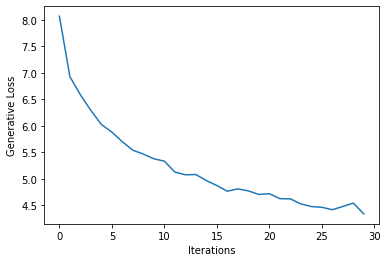

In [43]:
plt.plot(gen_loss_epochs)
plt.xlabel('Iterations')
plt.ylabel('Generative Loss')
plt.savefig('Figures/gen_loss_lsgan.jpg')

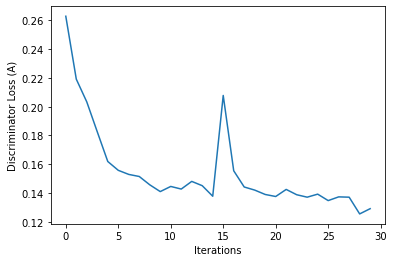

In [44]:
plt.plot(d_A_epochs)
plt.xlabel('Iterations')
plt.ylabel('Discriminator Loss (A)')
plt.savefig('Figures/dA_lsgan.jpg')

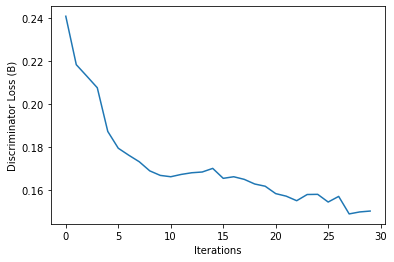

In [45]:
plt.plot(d_B_epochs)
plt.xlabel('Iterations')
plt.ylabel('Discriminator Loss (B)')
plt.savefig('Figures/dB_lsgan.jpg')

In [37]:
torch.save(net.state_dict(), f"Model Checkpoints/{blocks}blocks/CycleGAN.pth")
torch.save(net.genA2B.state_dict(), f"Model Checkpoints/{blocks}blocks/G_A2B_2epochs.pth")
torch.save(net.genB2A.state_dict(), f"Model Checkpoints/{blocks}blocks/G_B2A_2epochs.pth")
torch.save(net.discrimA.state_dict(), f"Model Checkpoints/{blocks}blocks/D_A_2epochs.pth")
torch.save(net.discrimB.state_dict(), f"Model Checkpoints/{blocks}blocks/D_B_2epochs.pth")

In [31]:
x_A_test, x_B_test = next(iter(test_loader))
x_A_test = x_A_test.to(device)
x_B_test = x_B_test.to(device)

In [32]:
renorm = transforms.Normalize(mean=[-1,-1,-1],std=[2,2,2])
with torch.set_grad_enabled(False):
    gen_A = net.generate(x_B_test, input_is_A=False)
    gen_B = net.generate(x_A_test, input_is_A=True)
    for b in range(gen_A.shape[0]):
        gen_A[b] = renorm(gen_A[b])
        gen_B[b] = renorm(gen_B[b])

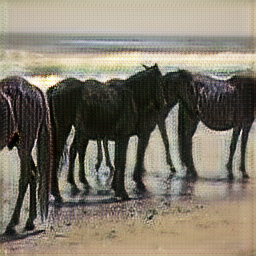

In [34]:
transforms.ToPILImage()(gen_A.cpu()[0])

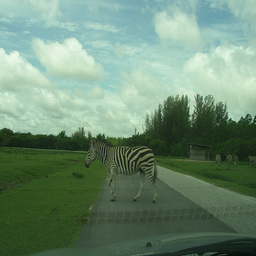

In [15]:
transforms.ToPILImage()(x_A_test.cpu()[2])

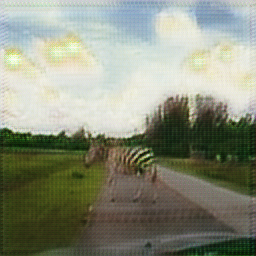

In [16]:
transforms.ToPILImage()(gen_B.cpu()[2])